#MonReader

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

Data Description:
The dataset was collected from page flipping video from smart phones and they was labelled as flipping and not flipping. The videos were clipped as short videos and was labelled as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

Goal(s):
Predict if the page is being flipped using a single image.

Data Exploration
Splitting data into train, test and valid
Data preprocessing
Modelling part
Results comparision
Conclusion

In [1]:
!pip install efficientnet_pytorch

In [2]:
import warnings
warnings.filterwarnings('ignore')
import shutil
from tqdm.notebook import tqdm
from __future__ import print_function, division
import pandas as pd
from torchsummary import  summary
from termcolor import colored
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import *
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets
import json
import requests
import os
import time
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
#grad cam
cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
import random
seed=random.randint(1000,9999)
print(seed)

3055


In [4]:
# Set the random seed for both numpy and pytorch
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
#set device as cuda if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device,"==> is used")

cpu ==> is used


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1- Data exploration

In [7]:
# Get training and testing dataset
train_flip_dir="/content/drive/My Drive/images/training/flip/"
train_flip = os.listdir(train_flip_dir)

train_notflip_dir ="/content/drive/MyDrive/images/training/notflip/"
train_notflip = os.listdir(train_notflip_dir)

test_flip_dir= "/content/drive/MyDrive/images/testing/flip/"
test_flip = os.listdir(test_flip_dir)

test_notflip_dir = "/content/drive/MyDrive/images/testing/notflip/"
test_notflip = os.listdir(test_notflip_dir)

In [8]:
#See the shape of each data folder
print('total training fliped images:', len(train_flip))
print('total training not fliped images:', len(train_notflip))
print('total testing fliped images:', len(test_flip))
print('total testing not fliped images:', len(test_notflip))

total training fliped images: 1062
total training not fliped images: 1100
total testing fliped images: 290
total testing not fliped images: 307


Define the smaller dimension in our image dataset

In [9]:
# define empty lists to store shapes
height_list=[]
width_list=[]

In [10]:
for l in [test_flip_dir,train_flip_dir, train_notflip_dir, test_notflip_dir]:
    liste=os.listdir(l)
    for i in liste:
        filename = os.path.join(l,i)
        img = Image.open(filename)
        height_list.append(img.size[1])
        width_list.append(img.size[0])

In [11]:
print("the min width in the images data is:", min(width_list))
print("the min height in the images data is:", min(width_list))

the min width in the images data is: 1080
the min height in the images data is: 1080


In [12]:
#set the minimum size as a base for further cropping
base_size=(1080,1080)

In [13]:
#take a test image example
test_img=test_flip_dir+test_flip[0]
img = Image.open(test_img)
img.size

(1080, 1920)

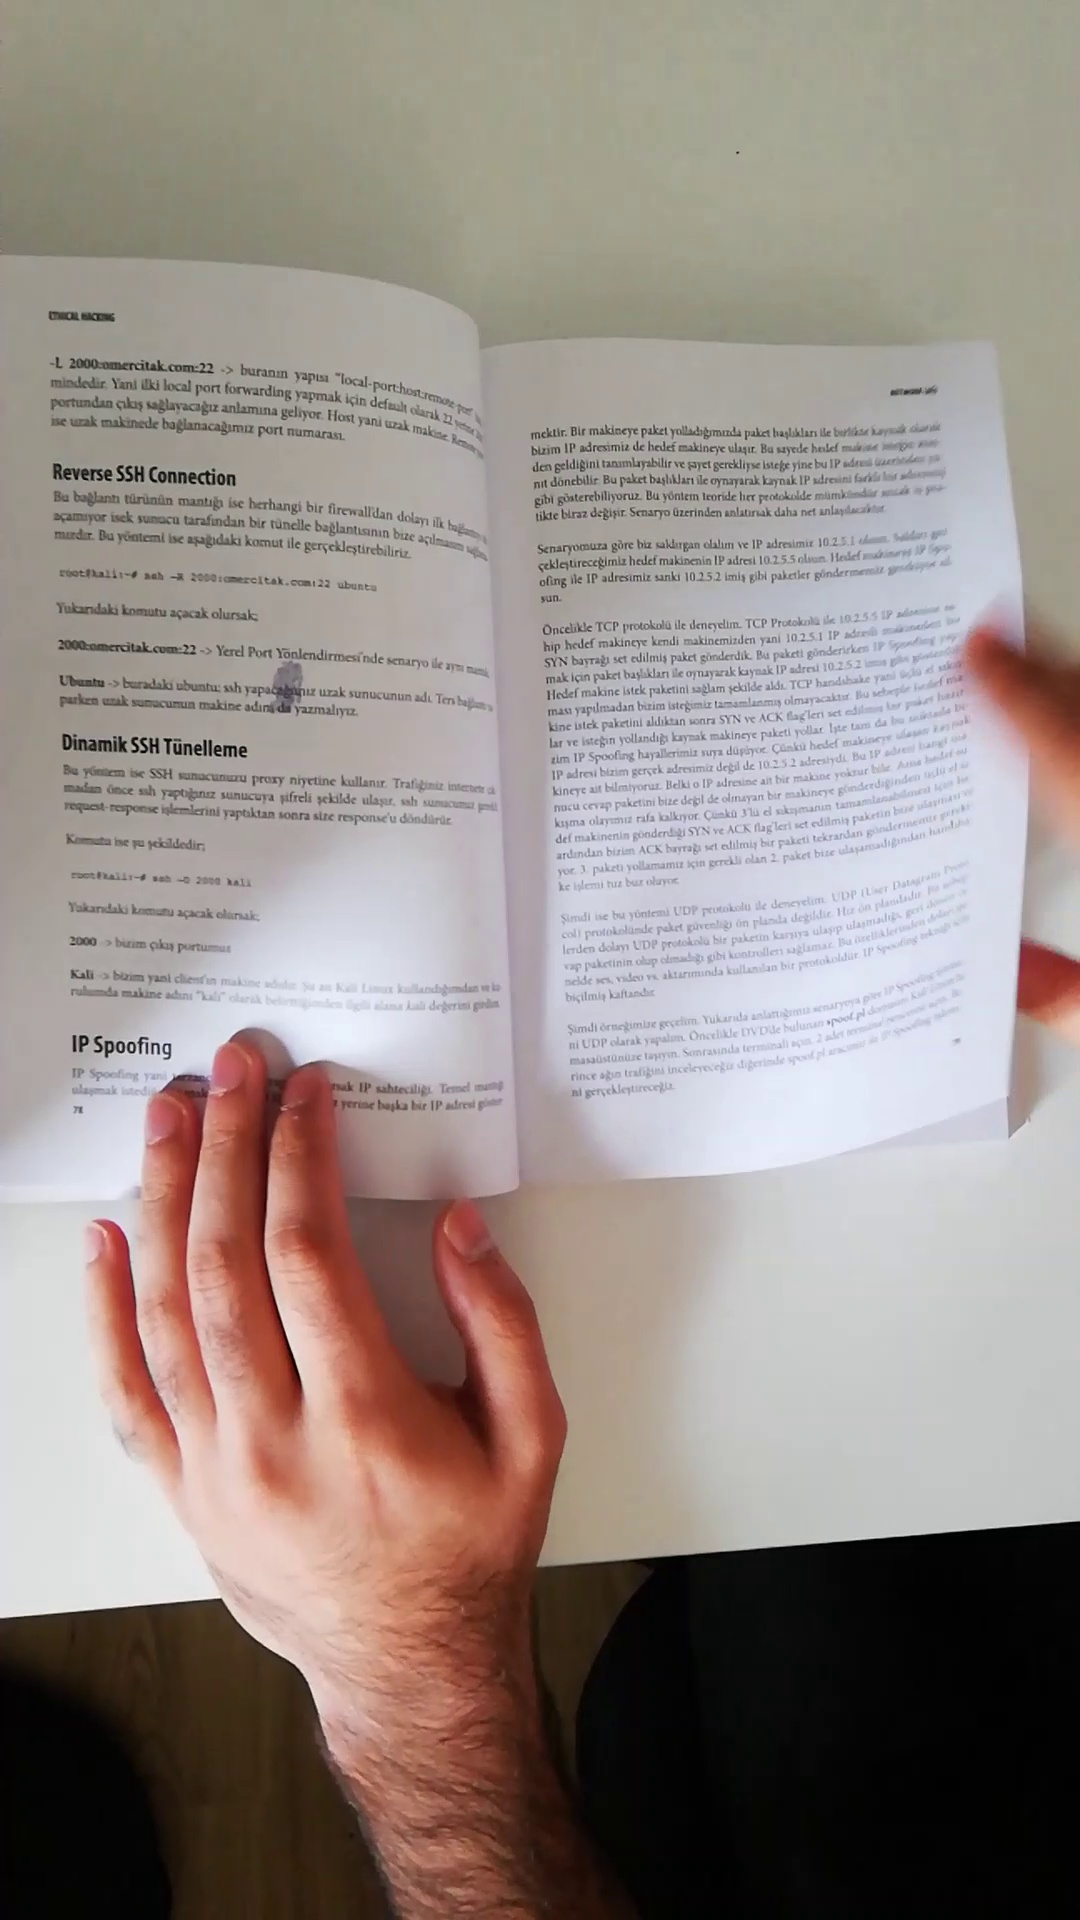

In [14]:
#see the original image
img

As we can see, the dimensions of images are different, so we should unify it for all the dataset as 1080*1080. I will do this in the preprocessing section.

#2. Split training data into train/ valid

In [15]:
X_noflip = np.array(train_notflip)
X_flip = np.array(train_flip)

#set 0 as flip and 1 as notflip
Y_noflip = np.ones(X_noflip.shape[0])
Y_flip = np.zeros(X_flip.shape[0])

X = np.concatenate((X_noflip,X_flip))
Y = np.concatenate((Y_noflip, Y_flip))

print(X.shape)
print(Y.shape)

(2162,)
(2162,)


In [17]:
# Let's take 10% for the validation dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y , test_size = 0.1, random_state = seed)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((1945,), (217,), (1945,), (217,))

So, there is 217 images in the validation dataset and 1945 in training dataset

In [18]:
#Run once
'''os.mkdir('/content/drive/MyDrive/images/valid')
valid_flip_dir='/content/drive/MyDrive/images/valid/flip'
valid_notflip_dir='/content/drive/MyDrive/images/valid/notflip'
os.mkdir(valid_flip_dir)
os.mkdir(valid_notflip_dir)

for i,j in zip(X_val,Y_val):
    if j ==0:# 0 --> flip
      shutil.move(train_flip_dir+i,valid_flip_dir)
    else:
      shutil.move(train_notflip_dir+i,valid_notflip_dir)'''

FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/images/valid'

In [19]:
#check size of folders
valid_flip_dir='/content/drive/MyDrive/images/valid/flip'
valid_notflip_dir='/content/drive/MyDrive/images/valid/notflip'
print(f'there are {len(os.listdir(valid_flip_dir))} images in the flip validation dataset')
print(f'there are {len(os.listdir(valid_notflip_dir))} images in the notflip validation dataset')
print('--------------> total valid is:',len(os.listdir(valid_flip_dir))+len(os.listdir(valid_notflip_dir)))

there are 111 images in the flip validation dataset
there are 130 images in the notflip validation dataset
--------------> total valid is: 241


#3- Data preprocessing
In this step, I will prepare the dataset for the modeling part, by applying transformers including data augmentation. I should notice that the preprocessing depends on the model I'll use.

Crope images to 1080*1080.\
Resize all images to have size (224, 224) as well as convert them to tensor.\
The ToTensor operation convert all tensors to lie between (0, 1).

In [20]:
#CNN transformer
CNN_transforms = {
    "training": transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
}

After initilizing the trasnformers, let's move to the next step, which is defining datasets. Thus, I'll use 2 main functions: ImageFolder() and Dataloader. ImageFolder saves the images and their respective labels according to the folders they’re present in, and the dataloader divides the data into different batches for training.

In [21]:
data_dir = "/content/drive/MyDrive/images/"

In [22]:
CNN_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          CNN_transforms[x])
                  for x in ['training', 'valid']}

CNN_train_loader = DataLoader(dataset=CNN_datasets['training'], shuffle=True, batch_size=8)
CNN_val_loader = DataLoader(dataset=CNN_datasets['valid'], shuffle=True, batch_size=1)

Let's visualize the distribution of training and testing datasets

In [23]:
CNN_datasets['valid'].class_to_idx
idx2class = {v: k for k, v in CNN_datasets['valid'].class_to_idx.items()}
idx2class

{0: 'flip', 1: 'notflip'}

number of samples in flip class: 1062
number of samples in notflip class: 1100


Text(0.5, 1.0, 'Distribution of training dataset')

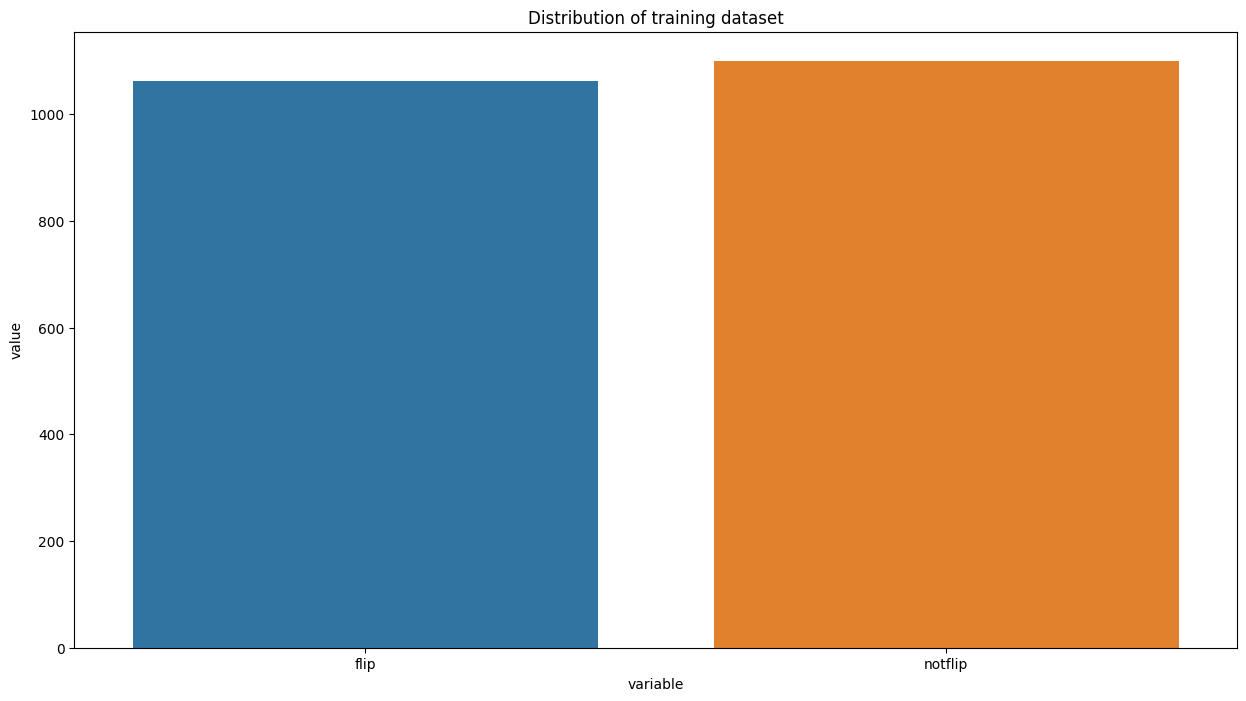

In [70]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    print("number of samples in flip class:", count_dict['flip'])
    print("number of samples in notflip class:", count_dict['notflip'])
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(CNN_datasets['training']), plot_title="Distribution of training dataset")

number of samples in flip class: 111
number of samples in notflip class: 130


Text(0.5, 1.0, 'Distribution of validation dataset')

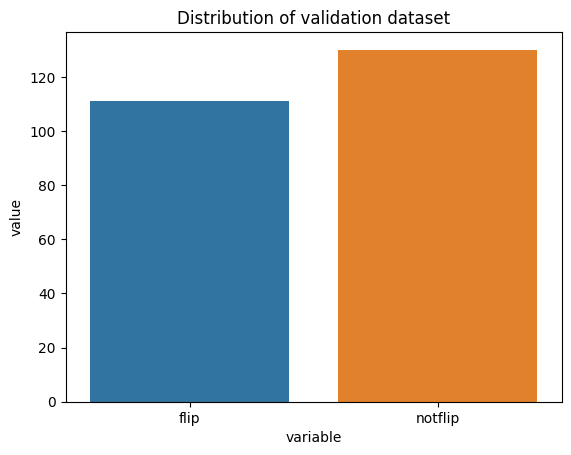

In [71]:
plot_from_dict(get_class_distribution(CNN_datasets['valid']), plot_title="Distribution of validation dataset")

From the plots above, we can infer the dataset is quite balanced

#4. Modeling part
I use 4 blocks of Conv layers. Each block consists of Convolution + BatchNorm + ReLU + Dropout layers.

In [24]:
class flipClassifier(nn.Module):
    def __init__(self):
        super(flipClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [25]:
CNN_model = flipClassifier()
CNN_model.to(device)
print(CNN_model)
criterion = nn.CrossEntropyLoss()#
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

flipClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [26]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [27]:
#define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats_CNN = {
    'train': [],
    "val": []
}
loss_stats_CNN = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    CNN_model.train()
    for X_train_batch, y_train_batch in CNN_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = CNN_model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION
    with torch.no_grad():
        CNN_model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in CNN_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = CNN_model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats_CNN['train'].append(train_epoch_loss/len(CNN_train_loader))
    loss_stats_CNN['val'].append(val_epoch_loss/len(CNN_val_loader))
    accuracy_stats_CNN['train'].append(train_epoch_acc/len(CNN_train_loader))
    accuracy_stats_CNN['val'].append(val_epoch_acc/len(CNN_val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(CNN_train_loader):.5f} | Val Loss: {val_epoch_loss/len(CNN_val_loader):.5f} | Train Acc: {train_epoch_acc/len(CNN_train_loader):.3f}| Val Acc: {val_epoch_acc/len(CNN_val_loader):.3f}')

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
print("Begin training.")
for epoch in range(1, 21):  # Loop for 20 epochs

    # TRAINING
    CNN_model.train()  # Set the model to training mode
    train_loss = 0
    train_correct = 0
    total_train = 0

    for X_train_batch, y_train_batch in CNN_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        y_train_batch = y_train_batch.squeeze()  # Ensure target is 1D
loss = criterion(y_train_pred, y_train_batch)  # Calculate loss


        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(y_train_pred, 1)  # Get predictions
        train_correct += (predicted == y_train_batch).sum().item()  # Count correct predictions
        total_train += y_train_batch.size(0)  # Track the total number of samples

    train_acc = train_correct / total_train  # Calculate training accuracy

    # VALIDATION
    CNN_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for X_val_batch, y_val_batch in CNN_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = CNN_model(X_val_batch)  # Forward pass
            loss = criterion(y_val_pred, y_val_batch)  # Calculate validation loss
            val_loss += loss.item()

            _, predicted = torch.max(y_val_pred, 1)  # Get predictions
            val_correct += (predicted == y_val_batch).sum().item()  # Count correct predictions
            total_val += y_val_batch.size(0)  # Track the total number of samples

    val_acc = val_correct / total_val  # Calculate validation accuracy

    # Print statistics for each epoch
    print(f'Epoch {epoch}/{20}: '
          f'Train Loss: {train_loss/len(CNN_train_loader):.4f}, '
          f'Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss/len(CNN_val_loader):.4f}, '
          f'Val Acc: {val_acc:.4f}')


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 26)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assuming CNN_model, CNN_train_loader, CNN_val_loader, and device are defined
# Assuming num_classes is the number of classes in your classification task

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)  # Adjust the learning rate as needed

print("Begin training.")
for epoch in range(1, 21):  # Loop for 20 epochs

    # TRAINING
    CNN_model.train()  # Set the model to training mode
    train_loss = 0
    train_correct = 0
    total_train = 0

    for X_train_batch, y_train_batch in CNN_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        y_train_pred = CNN_model(X_train_batch)  # Forward pass

        # Debug: Print shapes to verify the dimensions
        print("y_train_pred shape (before squeeze):", y_train_pred.shape)
        print("y_train_batch shape (before squeeze):", y_train_batch.shape)

        # Ensure output is 2D (batch_size, num_classes)
        if len(y_train_pred.shape) > 2:
            y_train_pred = y_train_pred.squeeze()  # Remove extra dimensions if needed
            print("y_train_pred shape (after squeeze):", y_train_pred.shape)

        # Ensure target is 1D for CrossEntropyLoss
        y_train_batch = y_train_batch.squeeze()  # Remove any unnecessary dimensions
        print("y_train_batch shape (after squeeze):", y_train_batch.shape)

        # Calculate loss
        loss = criterion(y_train_pred, y_train_batch)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(y_train_pred, 1)  # Get the index of the max log-probability
        train_correct += (predicted == y_train_batch).sum().item()  # Count correct predictions
        total_train += y_train_batch.size(0)  # Track the total number of samples

    train_acc = train_correct / total_train  # Calculate training accuracy

    # VALIDATION
    CNN_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for X_val_batch, y_val_batch in CNN_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = CNN_model(X_val_batch)  # Forward pass

            # Ensure output is 2D (batch_size, num_classes)
            if len(y_val_pred.shape) > 2:
                y_val_pred = y_val_pred.squeeze()  # Remove extra dimensions if needed

            # Ensure target is 1D for CrossEntropyLoss
            y_val_batch = y_val_batch.squeeze()

            # Calculate validation loss
            loss = criterion(y_val_pred, y_val_batch)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(y_val_pred, 1)  # Get the index of the max log-probability
            val_correct += (predicted == y_val_batch).sum().item()  # Count correct predictions
            total_val += y_val_batch.size(0)  # Track the total number of samples

    val_acc = val_correct / total_val  # Calculate validation accuracy

    # Print statistics for each epoch
    print(f'Epoch {epoch}/{20}: '
          f'Train Loss: {train_loss/len(CNN_train_loader):.4f}, '
          f'Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss/len(CNN_val_loader):.4f}, '
          f'Val Acc: {val_acc:.4f}')


Begin training.
y_train_pred shape (before squeeze): torch.Size([8, 2, 1, 1])
y_train_batch shape (before squeeze): torch.Size([8])
y_train_pred shape (after squeeze): torch.Size([8, 2])
y_train_batch shape (after squeeze): torch.Size([8])
y_train_pred shape (before squeeze): torch.Size([8, 2, 1, 1])
y_train_batch shape (before squeeze): torch.Size([8])
y_train_pred shape (after squeeze): torch.Size([8, 2])
y_train_batch shape (after squeeze): torch.Size([8])
y_train_pred shape (before squeeze): torch.Size([8, 2, 1, 1])
y_train_batch shape (before squeeze): torch.Size([8])
y_train_pred shape (after squeeze): torch.Size([8, 2])
y_train_batch shape (after squeeze): torch.Size([8])
y_train_pred shape (before squeeze): torch.Size([8, 2, 1, 1])
y_train_batch shape (before squeeze): torch.Size([8])
y_train_pred shape (after squeeze): torch.Size([8, 2])
y_train_batch shape (after squeeze): torch.Size([8])
y_train_pred shape (before squeeze): torch.Size([8, 2, 1, 1])
y_train_batch shape (befor

KeyboardInterrupt: 